<a href="https://colab.research.google.com/github/Ware-Hard-or-Soft/Generative-Models/blob/main/Diffusion_Model_on_MINST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

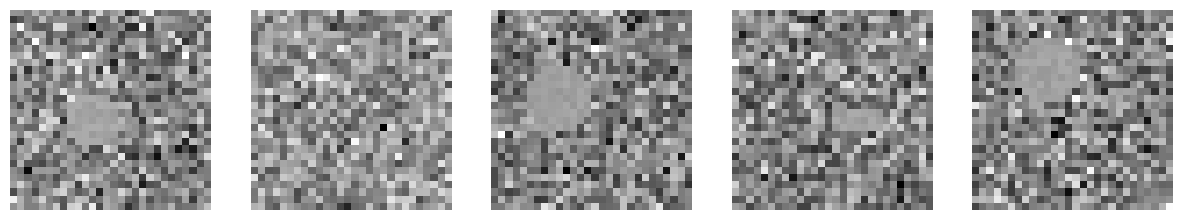

Epoch [1/5] Batch [0/157] Loss: 1.003957986831665
Epoch [1/5] Batch [100/157] Loss: 0.7105512619018555
Epoch [2/5] Batch [0/157] Loss: 0.667887806892395
Epoch [2/5] Batch [100/157] Loss: 0.6236385703086853


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Hyperparameters
num_steps = 1000  # Number of diffusion steps
image_size = 28  # Image size (28x28)
batch_size = 64
learning_rate = 1e-4

# Define a synthetic dataset class
class SyntheticMNIST(Dataset):
    def __init__(self, num_samples=10000, image_size=28):
        self.num_samples = num_samples
        self.image_size = image_size

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Generate a random "digit" as a noisy 28x28 image
        image = np.random.normal(0, 1, (self.image_size, self.image_size))

        # Add a synthetic shape (e.g., circle or line) to simulate a digit
        if idx % 2 == 0:
            # Draw a synthetic "circle" shape
            center_x, center_y = np.random.randint(8, 20, 2)
            radius = np.random.randint(3, 6)
            for x in range(self.image_size):
                for y in range(self.image_size):
                    if (x - center_x) ** 2 + (y - center_y) ** 2 < radius ** 2:
                        image[x, y] = np.random.uniform(0.5, 1.0)
        else:
            # Draw a synthetic "line" shape
            start_x, start_y = np.random.randint(5, 15, 2)
            end_x, end_y = start_x + np.random.randint(-5, 5), start_y + np.random.randint(5, 15)
            for x in range(start_x, min(end_x, self.image_size)):
                for y in range(start_y, min(end_y, self.image_size)):
                    image[x, y] = np.random.uniform(0.5, 1.0)

        # Convert to a tensor and normalize
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)
        label = 0  # Dummy label for compatibility with the DataLoader

        return image, label

# Instantiate the dataset and dataloader
synthetic_dataset = SyntheticMNIST(num_samples=10000)
train_loader = DataLoader(synthetic_dataset, batch_size=batch_size, shuffle=True)

# Show some samples from the synthetic dataset
def show_samples(dataset, num_samples=5):
    fig, axs = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        img, _ = dataset[i]
        axs[i].imshow(img.squeeze(), cmap='gray')
        axs[i].axis('off')
    plt.show()

show_samples(synthetic_dataset)

# Forward diffusion process: add Gaussian noise
def forward_diffusion(x0, t, noise_schedule):
    noise = torch.randn_like(x0)
    alpha_t = noise_schedule[t].view(-1, 1, 1, 1)
    x_t = torch.sqrt(alpha_t) * x0 + torch.sqrt(1 - alpha_t) * noise
    return x_t, noise

# Reverse process model: define a simple U-Net model
class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        x = self.conv4(x)
        return x

# Initialize model, optimizer, and noise schedule
model = SimpleUNet().to('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
noise_schedule = torch.linspace(0.0001, 0.02, num_steps).to('cuda' if torch.cuda.is_available() else 'cpu')  # Linear noise schedule

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    for batch_idx, (x0, _) in enumerate(train_loader):
        x0 = x0.to('cuda' if torch.cuda.is_available() else 'cpu')
        batch_size = x0.shape[0]

        # Randomly select time step t
        t = torch.randint(0, num_steps, (batch_size,)).long().to(x0.device)

        # Get noisy image x_t and noise used to corrupt x0
        x_t, noise = forward_diffusion(x0, t, noise_schedule)

        # Predict noise using model
        noise_pred = model(x_t)

        # Loss between actual noise and predicted noise
        loss = nn.MSELoss()(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{batch_idx}/{len(train_loader)}] Loss: {loss.item()}")

print("Training complete!")

# Sampling process to generate new images
def sample(num_samples, model, num_steps, noise_schedule):
    model.eval()
    samples = torch.randn(num_samples, 1, image_size, image_size).to(model.device)  # Start with random noise
    with torch.no_grad():
        for t in reversed(range(num_steps)):
            alpha_t = noise_schedule[t].view(-1, 1, 1, 1)
            noise_pred = model(samples)
            samples = (samples - torch.sqrt(1 - alpha_t) * noise_pred) / torch.sqrt(alpha_t)
            samples += torch.randn_like(samples) * torch.sqrt(1 - alpha_t) if t > 0 else 0
    return samples

# Generate samples
generated_samples = sample(5, model, num_steps, noise_schedule)

# Display generated samples
def show_generated_samples(samples):
    fig, axs = plt.subplots(1, samples.size(0), figsize=(15, 3))
    for i in range(samples.size(0)):
        axs[i].imshow(samples[i].cpu().squeeze(), cmap='gray')
        axs[i].axis('off')
    plt.show()

show_generated_samples(generated_samples)
